# Pràctica 1:

Nom dels alumnes del grup:
Albert Marín Blasco
Martí Lázaro Bagué

# Anàlisi exploratòria de dades (EDA) & ús d'eines avançades de Python

L'**anàlisi exploratòria de dades** (EDA, per les seves sigles en anglès, *Exploratory Data Analysis*) és un procés crític en la ciència de les dades que implica **explorar, resumir i visualitzar** les dades per a entendre les seves característiques principals. L'objectiu principal de l'EDA és revelar patrons, tendències i anomalies a partir de les dades, sense fer suposicions massa específiques o construir models massa complexes.

Aquí teniu alguns dels elements més importants de l'anàlisi exploratòria de dades:

+ **Visualització de dades**: A través de gràfics i gràfiques, es representen les dades per a veure distribucions, tendències i relacions. Això pot incloure histogrames, gràfics de barres, diagrames de dispersió, gràfics de caixa, etc.

+ **Estadístiques descriptives**: Es calculen estadístiques com la mitjana, la mediana, la desviació estàndard i altres mesures resum per a descriure les característiques bàsiques de les variables.

+ **Detecció d'anomalies**: Es busca identificar valors atípics o anòmals que puguin indicar errors o situacions especials en les dades.

+ **Imputació de dades faltants**: Si les dades tenen buits o valors faltants, es pot decidir com omplir aquests buits de manera adequada.

+ **Exploració de relacions**: Es busquen correlacions i relacions entre les diferents variables de les dades per a identificar connexions i dependencies.

+ **Agrupació de dades**: Es divideixen les dades en subconjunts basats en certes característiques per a analitzar-les més detingudament.

+ **Transformació de dades**: Es poden aplicar transformacions a les dades per a fer-les més adequades per a anàlisi posterior, com l'estandardització o la normalització.

* **Selecció de característiques**: Si es treballa amb un conjunt de dades amb moltes variables, es pot realitzar una selecció de característiques per a reduir la complexitat i millorar l'eficiència de l'anàlisi.

Python ofereix una àmplia gamma d'eines i biblioteques per a realitzar l'anàlisi exploratòria de dades (EDA). Algunes de les biblioteques més populars i útils són les següents:

+ **NumPy**: NumPy és una biblioteca fonamental per a la computació científica en Python. Proporciona funcionalitats per a treballar amb matrius i vectors, la qual cosa és essencial per a l'anàlisi de dades.

+ **Pandas**: Pandas és una biblioteca molt popular per a l'anàlisi de dades que ofereix estructures de dades com DataFrame i Series, que faciliten la manipulació i anàlisi de dades tabulars. Podeu utilitzar Pandas per a carregar, netejar i explorar les dades.

+ **Matplotlib**: Matplotlib és una biblioteca per a la visualització de dades que us permet crear una àmplia gamma de gràfics i gràfiques personalitzades. És ideal per a crear histogrames, diagrames de dispersió, gràfics de barres i moltes altres representacions gràfiques.

+ **Scipy**: SciPy és una biblioteca que amplia les funcionalitats de NumPy i proporciona eines addicionals per a l'anàlisi científic, inclosos estadístics i mètodes d'optimització.

+ **Scikit-learn**: Si esteu interessats en l'aprenentatge automàtic, Scikit-learn és una biblioteca essencial que ofereix eines per a la classificació, regressió, agrupació i altres tasques d'aprenentatge automàtic. També conté eines per a la selecció de característiques.

+ **Seaborn**: Seaborn és una biblioteca de visualització de dades basada en Matplotlib que simplifica la creació de gràfics estadístics atractius i informatius. És especialment útil per a la visualització de relacions i tendències en les dades.

## 0. Objectiu de la pràctica

L'**objectiu d'aquesta pràctica** és aprendre com fer una exploració sobre un conjunt de dades real, que al final ens permeti obtenir la resposta a diverses preguntes.

En aquesta pràctica explorarem les dades dels trajectes dels **taxis grocs de la ciutat de Nova York** durant varios anys.

En finalitzar aquesta pràctica, haureu de ser capaços de respondre la pregunta següent de forma detallada:

- **Com va afectar la pandèmia de la Covid l'ús dels taxis a Nova York?**

Pere respondre aquesta pregunta tant genèrica, ho podem descomposar en preguntes més concretes:

- Quina distribució d'encàrrecs segueixen els taxis i quina distància / durada tenen?
- Quines són les zones on més/menys taxis s'agafen?
- Quins horaris són els més usuals?
- Quins dies de la setmana i del mes s'utilitzen més?
- Etc.

### Instal·lació i importació de les llibreries necessàries

A més a més de les llibreries comentades, farem servir aquests mòduls de Python:

+ **PyArrow**: PyArrow és una biblioteca de Python que es fa servir per a l'intercanvi eficient de dades entre Python i altres llenguatges de programació, especialment C++ i Java. Aquesta biblioteca es desenvolupa com a part del projecte Apache Arrow, que és un projecte de codi obert dissenyat per a millorar el rendiment i la interoperabilitat de l'analítica de dades i les tecnologies relacionades. PyArrow permet la creació i la manipulació eficient de dades en forma de taules i columnes. PyArrow ofereix suport per a l'estrués similar a una taula de dades en altres llenguatges. Aquesta estructura de dades facilita l'organització i la manipulació de dades tabulars.

In [1]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm import tqdm
import pyarrow.parquet as pq

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Descàrrega de dades

In [3]:
# Variables globals: els anys que estudiarem

YEARS = [2019, 2020, 2021]

In [4]:
# Descàrrega de les dades: Trip Record Data
# https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

# Aquesta cel·la triga uns quants minuts a executar-se

for year in YEARS:
    if not os.path.exists(f'data/{year}'):
        print("Descarregant:", year)
        os.makedirs(f'data/{year}', exist_ok=True)
        for month in tqdm(range(1, 13)):
            urllib.request.urlretrieve(f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet', f'data/{year}/{month:02d}.parquet')

## 2. Neteja de dades

Per tal de tenir unes dades netes i útils, eliminarem totes aquells trajectes (files del conjunt de dades)  que continguin informació *corrupte*. Per exemple, cal verificar que no es dóna cap d'aquests casos:

- Presència de *missing data* (camps/columnes de les dades sense valor).
- L'hora de recollida és posterior a la finalització del trajecte.
- Hi ha viatges amb un nombre absurd de passatgers?
- Hi ha viatges massa llargs o massa curts?
- Hi ha pagaments negatius?
- Etc.

A més a més, hem de considerar aspectes concrets d'aquestes dades:

+ Hi pot haver viatges impossibles segons la normativa. Consulteu la normativa i afegiu les verificacions que corresponguin:
    + [Més viatgers que els permesos](https://www1.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page) o [velocitats il·legals](https://www.speed-limits.com/newyork).
    + [Limit de persones permeses a un yellow taxicab](https://drive.google.com/file/d/1eiV7wdm7WrkRlM9bmekCRM6GY3Yq6GI2/view?usp=sharing)

De totes les columnes que tenen les dades, **només considerarem les següents per contestar les preguntes:

- *tpep_pickup_datetime*: The date and time when the meter was engaged.
- *tpep_dropoff_datetime*: The date and time when the meter was disengaged.
- *Passenger_count*: The number of passengers in the vehicle.
- *Trip_distance*: The elapsed trip distance in miles reported by the taximeter.
- *PULocationID*: TLC Taxi Zone in which the taximeter was engaged
- *DOLocationID*: TLC Taxi Zone in which the taximeter was disengaged
- *Payment_type*: A numeric code signifying how the passenger paid for the trip.
    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip
- *Fare_amount*: The time-and-distance fare calculated by the meter.
- *Total_amount*: The total amount charged to passengers.

In [46]:
# Carreguem les dades a un dataframe de pandas
# Per agilitzar els càlculs i reduir el temps de càlcul durant el desenvolupament i
# eliminem les columnes que no són útils

# Per desenvolupar el codi podem treballar amb una mostra
# uniforme de les dades (en principi, 1 fila de cada 100).

def load_table(year, month, sampling = 100):
    """
    Funció que llegeix les dades descarregades i les converteix a un DataFrame
    """
    data = pq.read_table(f'data/{year}/{str(month).zfill(2)}.parquet').to_pandas()
    required_data = ['tpep_pickup_datetime',
                 'tpep_dropoff_datetime',
                 'passenger_count',
                 'trip_distance',
                 'PULocationID',
                 'DOLocationID',
                 'payment_type',
                 'fare_amount',
                 'total_amount']
    return data[required_data][::sampling]

# explorem una mica les dades
test = load_table(2019, 1)
test.shape

(76967, 9)

In [47]:
# visualitzem algunes dades
test.tail(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
7695700,2019-01-30 22:40:39,2019-01-30 22:41:55,NaN,0.17,256,256,0,39.95,43.0
7695800,2019-01-31 06:58:00,2019-01-31 07:44:00,NaN,17.57,108,56,0,77.45,81.0
7695900,2019-01-31 07:46:00,2019-01-31 08:37:00,NaN,10.85,91,231,0,37.19,46.5
7696000,2019-01-31 09:00:00,2019-01-31 09:45:00,NaN,4.11,162,231,0,35.95,39.5
7696100,2019-01-31 11:18:35,2019-01-31 11:41:41,NaN,4.52,244,75,0,29.45,32.5
7696200,2019-01-31 14:01:00,2019-01-31 15:08:00,NaN,16.32,36,21,0,59.15,62.7
7696300,2019-01-31 15:35:00,2019-01-31 15:55:00,NaN,4.96,18,220,0,26.31,32.5
7696400,2019-01-31 17:11:00,2019-01-31 18:05:00,NaN,14.78,107,130,0,50.69,60.0
7696500,2019-01-31 18:33:00,2019-01-31 18:58:00,NaN,8.80,107,69,0,39.45,43.0
7696600,2019-01-31 23:31:07,2019-01-31 23:51:40,NaN,9.17,140,47,0,43.45,46.5


###  Exercici A

+ Un cop llegides les dades a una taula de Pandas, implementa una funció que faci el procés de neteja que consideris necessari. Per determinar què és necessari, **explora** els valors que apareixen a cada columna del dataframe de Pandas i decideix què cal fer. Per exemple: eliminar les files on falten dades, eliminar les files amb pickup_datetime or dropoff_datetime que no es corresponen, eliminar les files amb 0 passatgers o amb més passatgers que els que permet la normativa, eliminar les files on les zones de taxis a NY no estiguin entre la 1 a la 263, eliminar les files amb pagaments negatius, etc.

> *Nota: Les columnes `Datatime` són un subtipus de dades de Pandas anomenades `datetime`.  Busca com tractar de forma eficient aquest tipus de dades en Pandas.*

In [48]:
test.tail()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
7696200,2019-01-31 14:01:00,2019-01-31 15:08:00,NaN,16.32,36,21,0,59.15,62.7
7696300,2019-01-31 15:35:00,2019-01-31 15:55:00,NaN,4.96,18,220,0,26.31,32.5
7696400,2019-01-31 17:11:00,2019-01-31 18:05:00,NaN,14.78,107,130,0,50.69,60.0
7696500,2019-01-31 18:33:00,2019-01-31 18:58:00,NaN,8.80,107,69,0,39.45,43.0
7696600,2019-01-31 23:31:07,2019-01-31 23:51:40,NaN,9.17,140,47,0,43.45,46.5


In [49]:
def velocitat_mitja(pickup, dropoff, distance) -> float:
    temps = (dropoff-pickup).total_seconds() / 3600
    if temps == 0:
        return 66
    velocitat = distance/temps
    return velocitat

def clean_data(data: pd.DataFrame, year: int, month: int) -> pd.DataFrame:
    """
    Funció que neteja (una mostra de) les dades per un mes donat.
    """

    # AQUÍ EL TEU CODI
    data = data.dropna()
    
    data = data[data["tpep_pickup_datetime"] < data["tpep_dropoff_datetime"]]

    data = data[(data["passenger_count"] > 0) & (data["passenger_count"] < 7)]

    data = data[data["trip_distance"] > 0]

    data = data[((data["PULocationID"] > 0) & (data["PULocationID"] < 264))
            & ((data["DOLocationID"] > 0) & (data["DOLocationID"] < 264))]

    data = data[(data["payment_type"] == 1) | (data["payment_type"] == 2)]

    data = data[(data["fare_amount"] < data["total_amount"])
            & ((data["fare_amount"] > 0) & (data["total_amount"] > 0))]

    data = data[(data["tpep_pickup_datetime"].dt.year == year)
            & (data["tpep_pickup_datetime"].dt.month == month)
            & (data["tpep_dropoff_datetime"].dt.year == year)
            & (data["tpep_dropoff_datetime"].dt.month == month)]

    data = data[
            data.apply(
                lambda x: velocitat_mitja(
                    x["tpep_pickup_datetime"],
                    x["tpep_dropoff_datetime"],
                    x["trip_distance"]) < 66, axis = 1)]
    
    data = data.reset_index(drop=True)
    
    return data

test = clean_data(test, 2019,1)

# el nombre de registres que queden ha de ser al voltant dels 62.000
test.shape

(72895, 9)

In [50]:
# visualitzem algunes dades
test.tail()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
72890,2019-01-31 23:52:01,2019-01-31 23:57:25,1.0,1.20,142,239,1,6.5,9.36
72891,2019-01-31 15:31:51,2019-01-31 15:43:41,3.0,1.62,186,161,1,9.5,13.50
72892,2019-01-31 23:13:39,2019-01-31 23:19:36,1.0,2.19,142,151,1,8.0,11.16
72893,2019-01-31 18:44:20,2019-01-31 18:50:12,1.0,0.59,161,162,2,5.5,6.80
72894,2019-01-31 23:32:17,2019-01-31 23:47:35,2.0,2.52,164,113,1,11.5,14.00


###  Exercici B

+ Escriu una funció que transformi una taula original a una nova taula, més adequada per tal de dur a terme l'exploració necessària. Podeu afegir columnes addicionals (per exemple, columnes per l'any o el mes), precalcular valors, etc.

> Per exemple, podem transformar les dades per treballar amb les unitats de kilòmetres i hores per a representar les durades, distàncies i velocitats del trajecte. El motiu és, per una banda, que estem familiaritzades amb el Sistema Internacional d'Unitats (d'aquí el canvi de milles a km). I per altra, optar pels km i no pels metres degut a l'ordre de magnitud de les dades.

> Un cop tenim les dades normalitzades i enriquides hem de pensar en la neteja una altra vegada. Per exemple: Eliminar aquelles files que tinguin velocitat max excedeixi limit permès per llei https://www.speed-limits.com/newyork

In [51]:
def calculate_duration(data: pd.DataFrame) -> pd.Series:
    """
    Calcula la durada de cada viatge en hores.
    Parameters:
        data (pandas.DataFrame): DataFrame amb les columnes 'tpep_pickup_datetime' i 'tpep_dropoff_datetime'
    Returns:
        pandas.Series: Serie amb la durada de cada viatge en hores.
    """
    return (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 3600


def post_processing(data):
    """
    Funció on implementar qualsevol tipus de postprocessament necessari.
    """
    # AQUÍ EL TEU CODI

    ##Després de mirar els diferents exercicis veiem que no ens interessa:
    ##  Fareamount
    ##  Totalamount
    ##  Les distancies es volen en Km (milles x 1.60934 = Km)
    ##  Potser volem dat i hores per separat
    
    # Primer fem les conversions
    data["trip_distance"] = ((data["trip_distance"])*(1.60934))
    data['trip_duration'] = calculate_duration(data)
    
    # Ara netejarem les columnes que no ens interessin
    data.drop(columns=['fare_amount', 'total_amount', 'payment_type'], axis=1, inplace=True)

    # Seprem PU
    data["month"] = data["tpep_pickup_datetime"].dt.month
    data["year"] = data["tpep_pickup_datetime"].dt.year

    # Afegim dropoff i pickup day, month, year...
    # Hem decidit fer tantes columnes per tal d'evitar ifs anidats en altres exercicis
    # I per accedir-hi de forma més senzilla
    data["pickup_hour"] = data["tpep_pickup_datetime"].dt.hour
    data["pickup_day"] = data["tpep_pickup_datetime"].dt.dayofweek
    data["pickup_week"] = data["tpep_pickup_datetime"].dt.isocalendar().week
    data["pickup_month"] = data["tpep_pickup_datetime"].dt.month
    data["pickup_year"] = data["tpep_pickup_datetime"].dt.year

    data["dropoff_hour"] = data["tpep_dropoff_datetime"].dt.hour
    data["dropoff_day"] = data["tpep_dropoff_datetime"].dt.dayofweek
    data["dropoff_week"] = data["tpep_dropoff_datetime"].dt.isocalendar().week
    data["dropoff_month"] = data["tpep_dropoff_datetime"].dt.month
    data["dropoff_year"] = data["tpep_dropoff_datetime"].dt.year


    
    data["v_mean"] = data["trip_distance"]/((data["tpep_dropoff_datetime"] - data["tpep_pickup_datetime"]).dt.total_seconds() / 3600)
    
    return data

test = post_processing(test)

# el nombre de registres que queden ha de ser al voltant dels 58.000

test.shape

(72895, 20)

In [52]:
#Per mirar si els valors s'han alterat corerctament
# visualitzem algunes dades
test.tail()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,trip_duration,month,year,pickup_hour,pickup_day,pickup_week,pickup_month,pickup_year,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,dropoff_year,v_mean
72890,2019-01-31 23:52:01,2019-01-31 23:57:25,1.0,1.931208,142,239,0.090000,1,2019,23,3,5,1,2019,23,3,5,1,2019,21.457867
72891,2019-01-31 15:31:51,2019-01-31 15:43:41,3.0,2.607131,186,161,0.197222,1,2019,15,3,5,1,2019,15,3,5,1,2019,13.219255
72892,2019-01-31 23:13:39,2019-01-31 23:19:36,1.0,3.524455,142,151,0.099167,1,2019,23,3,5,1,2019,23,3,5,1,2019,35.540719
72893,2019-01-31 18:44:20,2019-01-31 18:50:12,1.0,0.949511,161,162,0.097778,1,2019,18,3,5,1,2019,18,3,5,1,2019,9.710904
72894,2019-01-31 23:32:17,2019-01-31 23:47:35,2.0,4.055537,164,113,0.255000,1,2019,23,3,5,1,2019,23,3,5,1,2019,15.904066


Amb això podem crear un nou dataset (una única taula) que contingui tota la informació dels anys: 2019, 2020, 2021.

In [54]:
df = pd.concat([clean_data(load_table(year, month), year, month)
                for year in YEARS
                for month in range(1, 13)],
                ignore_index=True, sort=False)
df = post_processing(df)

# el nombre de registres que queden ha de ser al voltant dels 1.000.000

df.shape

(1307275, 20)

In [14]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,trip_duration,month,year,pickup_hour,pickup_day,pickup_week,pickup_month,pickup_year,dropoff_hour,dropoff_day,dropoff_week,dropoff_month,dropoff_year,v_mean
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.414010,151,239,0.111111,1,2019,0,1,1,1,2019,0,1,1,1,2019,21.726090
1,2019-01-01 00:43:00,2019-01-01 00:52:16,1.0,2.574944,238,236,0.154444,1,2019,0,1,1,1,2019,0,1,1,1,2019,16.672299
2,2019-01-01 00:30:01,2019-01-01 00:33:50,1.0,1.110445,143,239,0.063611,1,2019,0,1,1,1,2019,0,1,1,1,2019,17.456771
3,2019-01-01 00:34:48,2019-01-01 00:46:16,2.0,3.234773,236,74,0.191111,1,2019,0,1,1,1,2019,0,1,1,1,2019,16.926140
4,2019-01-01 00:49:44,2019-01-01 01:07:18,2.0,5.632690,263,164,0.292778,1,2019,0,1,1,1,2019,1,1,1,1,2019,19.238789


## 3. Visualització de dades anuals

Començarem l'anàlisi de les dades amb la següent pregunta: **S'ha incrementat o ha disminuït amb la covid la quantitat de viatges anuals fets amb taxis?**

Per fer-ho, n'hi ha prou amb crear una figura de barres on es visualitzin la quantitat de viatges per any.

### Exercici C

+ Escriu una funció basada en `matplotlib` que generi aquesta gràfica.

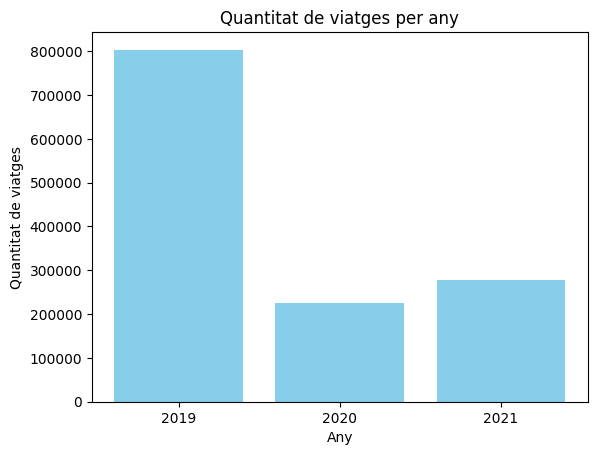

In [15]:
def bar_plot(df, column, xlabel, ylabel, title):
    """
    Funció que crea una figura de barres a partir del dataframe i
    la columna que conté la informació
    """

    # AQUÍ EL TEU CODI

    values = df[column].value_counts().sort_index()

    ax = plt.gca()

    ax.bar(values.index.astype(str), values.values, color='skyblue')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    

bar_plot(df,
         'year',
         'Any',
         'Quantitat de viatges',
         'Quantitat de viatges per any')

+ Visualitza ara en tres gràfiques, el nombre de viatges per mesos de cada any, fent servir la funció anterior.

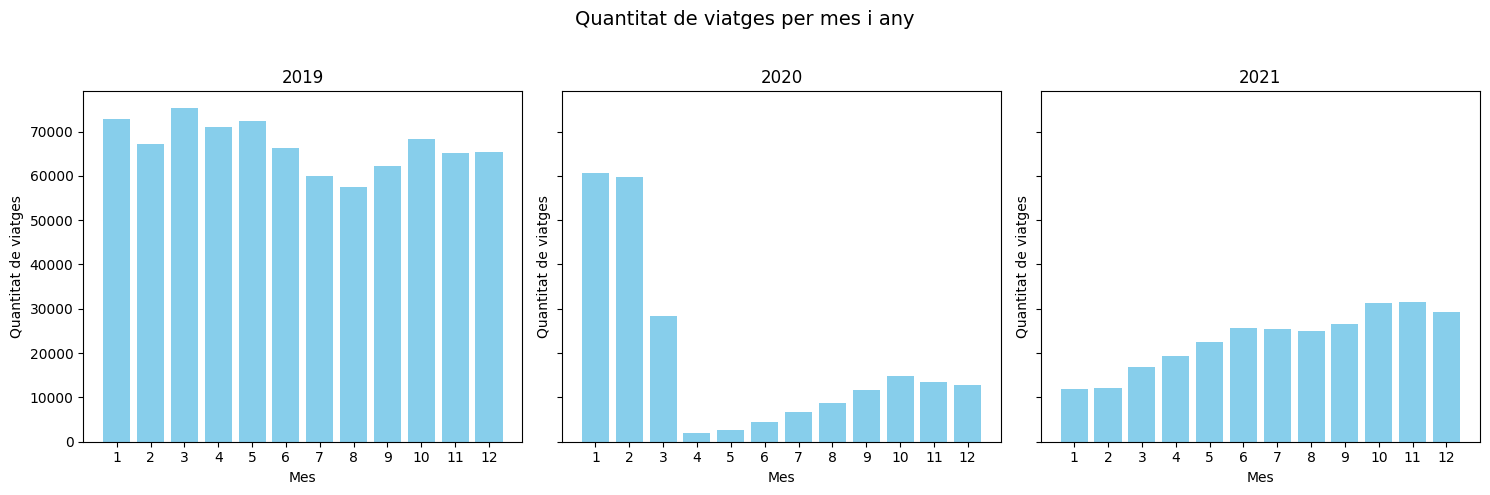

In [16]:
# AQUÍ EL TEU CODI
def show_img():
    fig, axes = plt.subplots(1, len(YEARS), figsize=(15, 5), sharey=True)
    
    for ax, year in zip(axes, YEARS):
        plt.sca(ax)
        df_year = df[df['year'] == year]
        bar_plot(df_year, 'month', "Mes", "Quantitat de viatges", f"{year}")
    
    plt.suptitle("Quantitat de viatges per mes i any", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

show_img()

+ Pregunta:
    + És el comportament que esperàveu? Explica la teva interpretació de les dades tenint en compte el que va passar al món durant aquests anys.

> Resposta

> Sí: Veiem que el nombre de viatges va baixar durant 2020 en concret a partir del març. Després, el valor es va recuperant a poc a poc, pero encara està lluny d'assolir les xifres del 2019 i la primera part del 2020.
> Per tant, creiem que el covid va tenir una influència clau en la quantitat de viatges de taxi fets a Nova York, reduint extremadament el valor, segurament donat la crisi posterior que va ocasionar, juntament amb les despatxades generals de les empreses.

+ Visualitza **quants passatgers hi ha per taxi i per any**. Crea una figura **amb tres subfigures** (una per any) on es pugui veure el recompte de passatgers per any.
+ Després repetiu el mateix gràfic visualitzant el % enlloc dels nombres absoluts (utilitzeu el paràmetre *norm = True*).

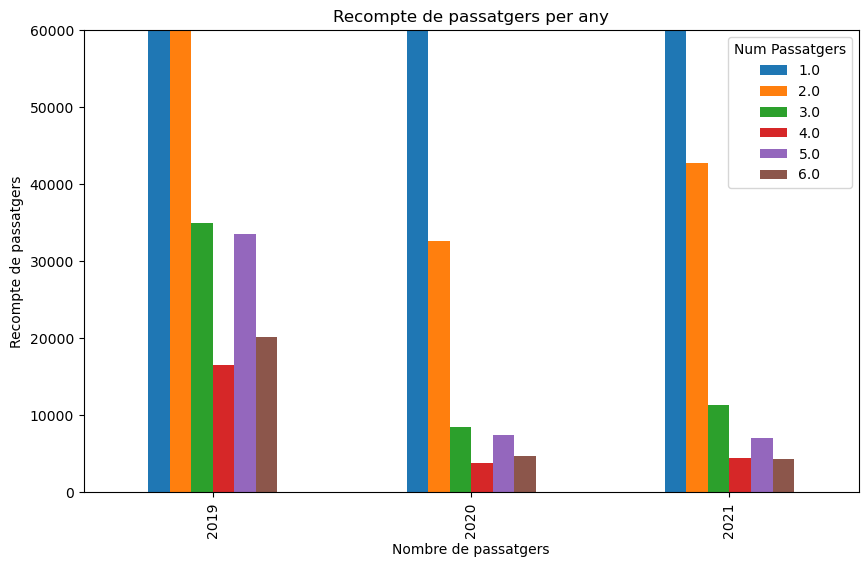

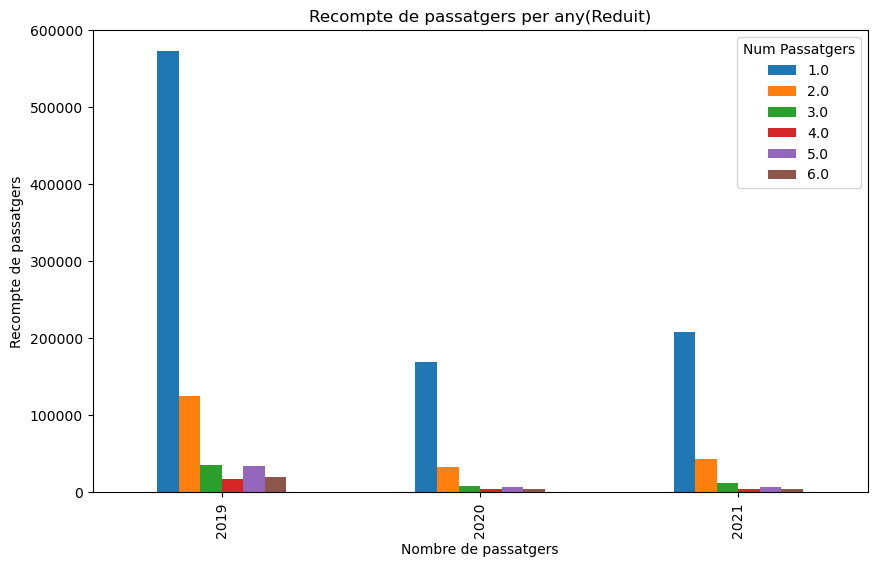

In [73]:
def passengers_taxi_year(df, ylim, xlabel, ylabel, title, norm = False):
    """
    Funció que visualitza quants passatgers hi ha per taxi i per any
    """
    
    viatges = pd.crosstab(df['year'], df['passenger_count'])

    if norm:
        viatges = viatges.div(viatges.sum(axis=1), axis=0) * 100
    
    
    ax = viatges.plot(kind='bar', figsize=(10, 6))
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Num Passatgers', loc='upper right')
    plt.ylim(ylim)
    plt.show()


passengers_taxi_year(df,
                     (0, 60000),
                     'Nombre de passatgers',
                     'Recompte de passatgers',
                     'Recompte de passatgers per any')

passengers_taxi_year(df,
                     (0, 600000),
                     'Nombre de passatgers',
                     'Recompte de passatgers',
                     'Recompte de passatgers per any(Reduit)')

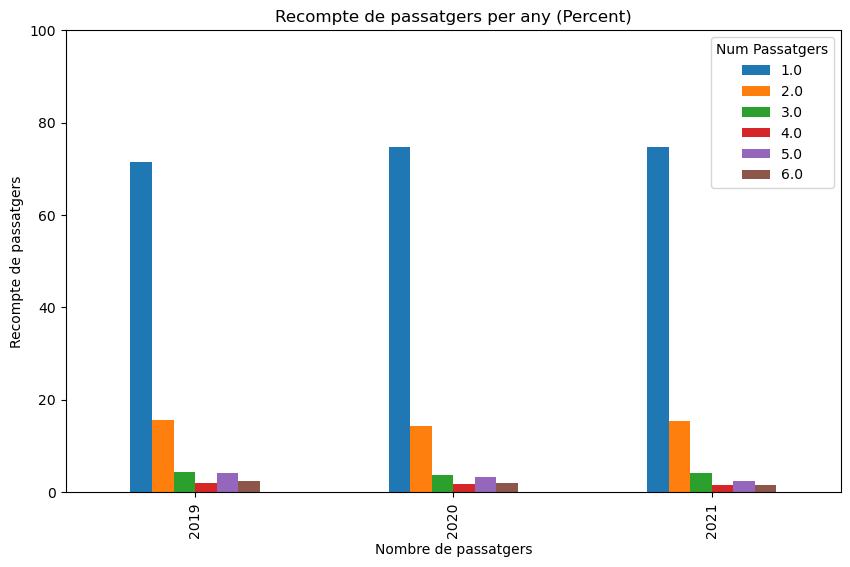

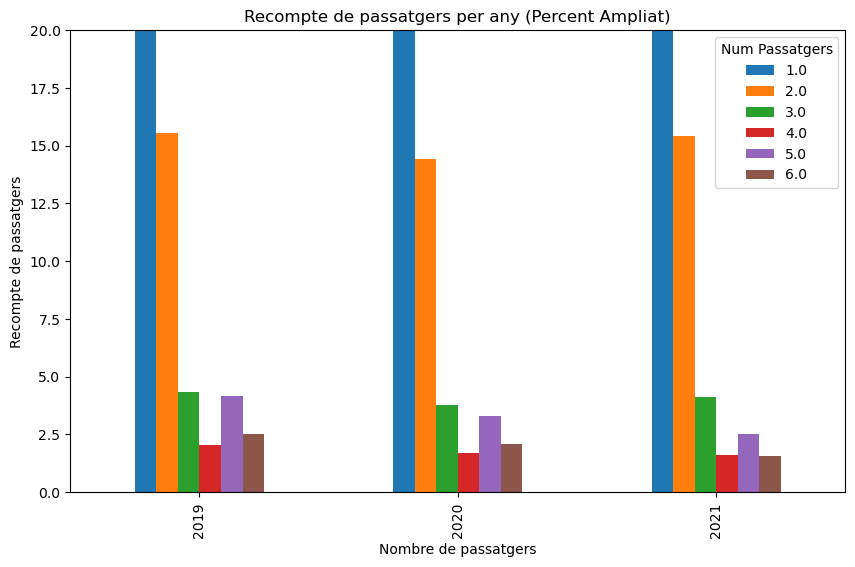

In [72]:
passengers_taxi_year(df,
                     (0, 100),
                     'Nombre de passatgers',
                     'Recompte de passatgers',
                     'Recompte de passatgers per any (Percent)', norm = True)

passengers_taxi_year(df,
                     (0, 20),
                     'Nombre de passatgers',
                     'Recompte de passatgers',
                     'Recompte de passatgers per any (Percent Ampliat)', norm = True)

+ Com descriurieu de forma **qualitativa** l'efecte de la covid sobre els taxis en base a l'anàlisi fet fins ara?
+ Podeu calcular de forma **quantitativa** la magnitud dels canvis que heu detectat? Escriviu una funció que calculi una sèrie d'indicadors quantitatius (per exemple, quin canvi percentual hi ha en el nombre de viatges d'una sola persona, la mitja de passatgers per viatge, etc.).

> Respostes
>
> Podem veure molt clarament els efectes del covid, i per tant, de la pandemia. En el 2020 hi ha una davallada de passatgers molt notable, que sembla extendres fins al 2021 (com a mínim), entenent que aquest efecte ve donat a les moltes despatxades que va haver tant en el 2020 com en el 2021 per la crisi que va causar la pandèmia, fent que moltes empreses tanquessin o reduïssin personal.

> Resposta:



## 4. Quantitat de viatges per diferents agregacions

Fins ara hem vist la quantitat de viatges que hi ha hagut a nivell de mesos i anys.

Ara podem estudiar l'efecte de la covid en el nombre de trajectes si **agreguem** les dades per hores, dies de la setmana, setmanes de l'any, etc.

### Exercici D

+ Escriu una única funció genèrica que visualitzi el nombre de trajectes per les agregacions de dades comentades i per cada any. Fes servir gràfics de línies discontínues (una línia per cada any) per veure'n l'evolució i marca amb una rodona o creu allà on està el valor.

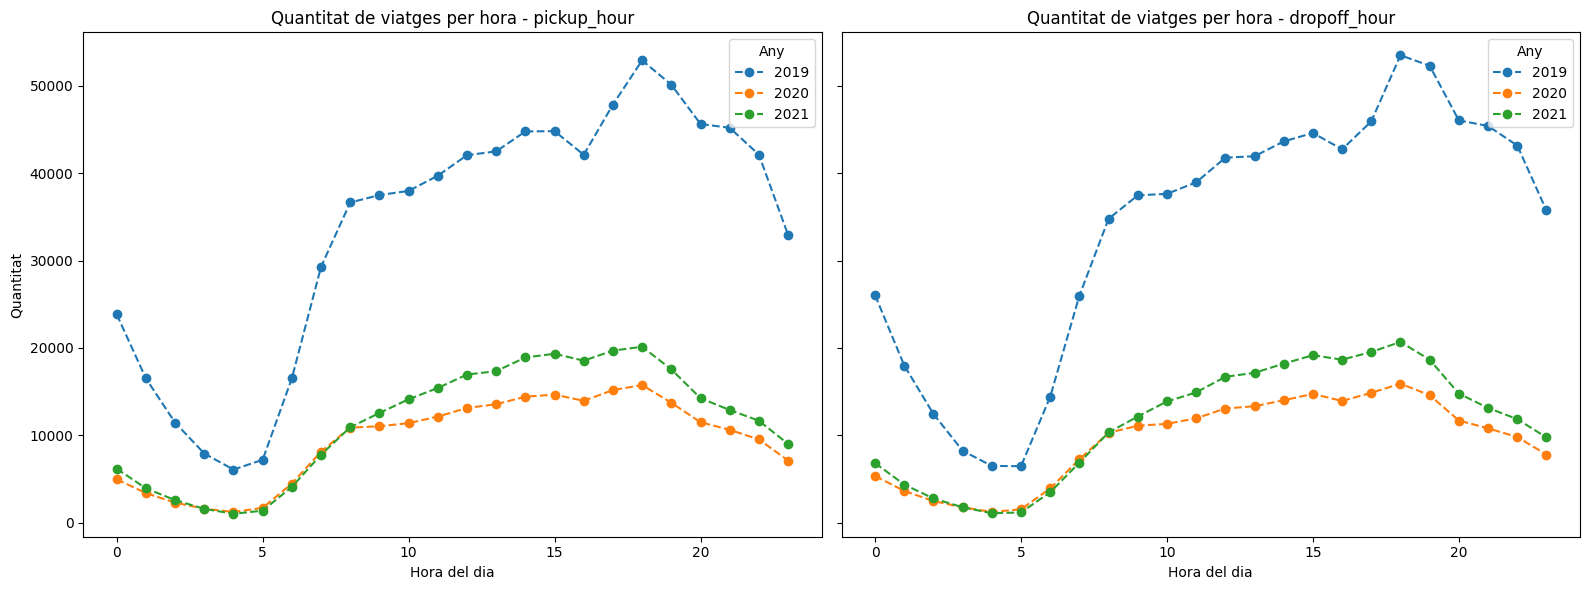

In [19]:
def visualize_trips(df, columns, title, xlabel, ylabel):
    """
    Funció que visualitza els viatges per diferents agregacions de dades
    """
    # Fer dos grafics per pickup_hour i dropoff_hour

    # AQUÍ EL TEU CODI

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    
    for ax, col in zip(axes, columns):
        viatges = pd.crosstab(df[col], df['year'])
        viatges.plot(kind='line', marker='o', linestyle='--', ax=ax)
        ax.set_title(f"{title} - {col}")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(title='Any', loc='upper right')
    
    plt.tight_layout()
    plt.show()

    

visualize_trips(df,
                ['pickup_hour', 'dropoff_hour'],
                title = 'Quantitat de viatges per hora',
                xlabel = 'Hora del dia', ylabel = 'Quantitat')

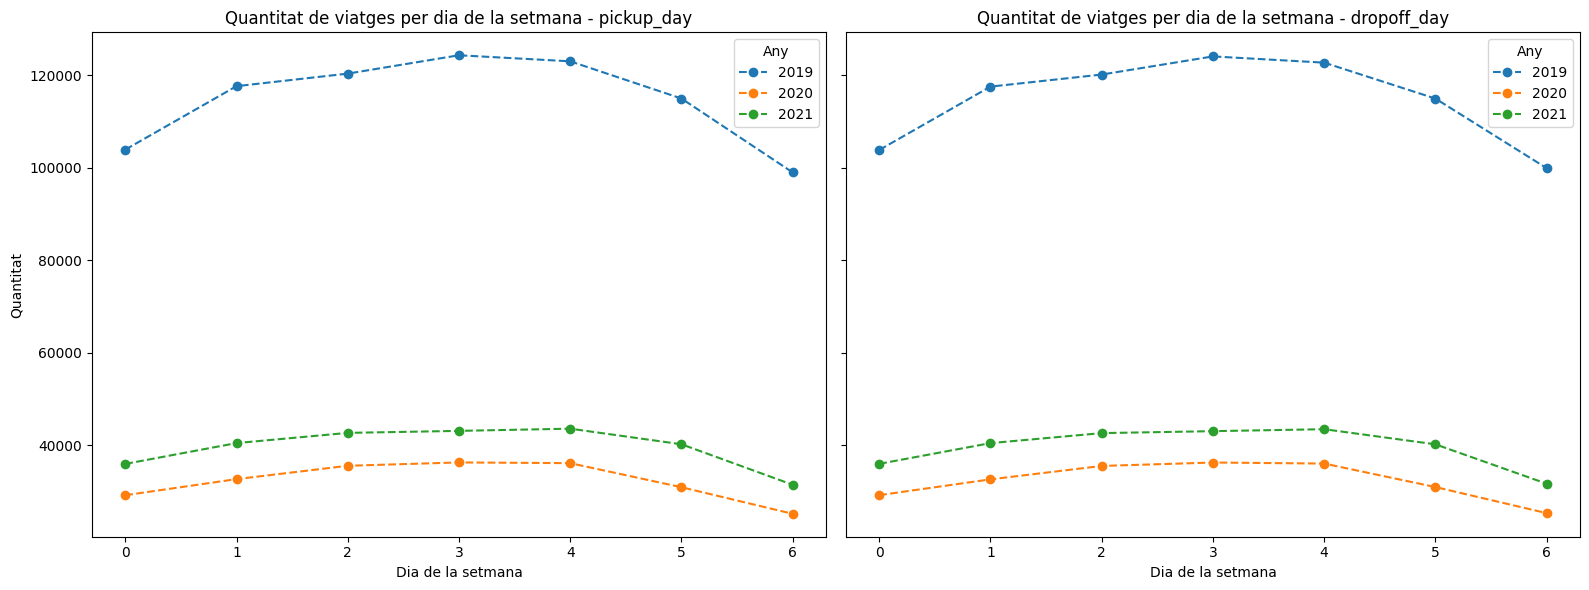

In [20]:
visualize_trips(df,
                ['pickup_day', 'dropoff_day'],
                title = 'Quantitat de viatges per dia de la setmana',
                xlabel = 'Dia de la setmana',
                ylabel = 'Quantitat')

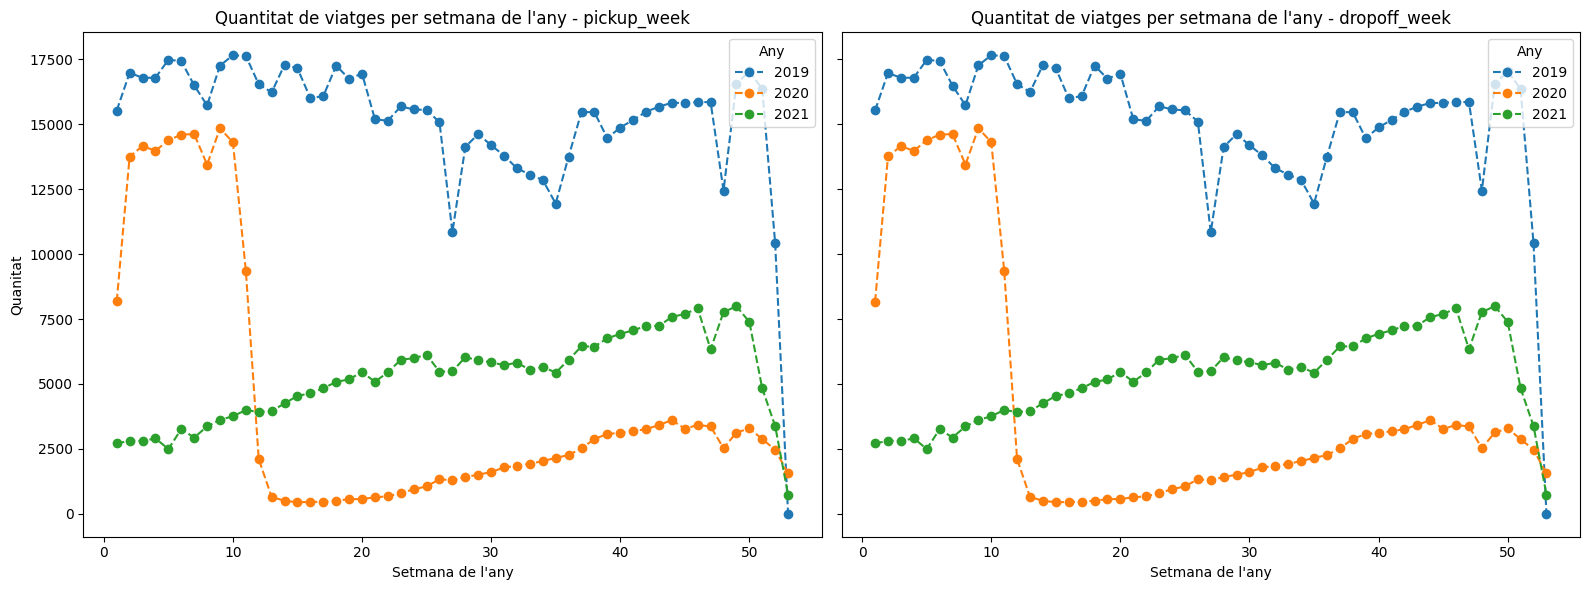

In [21]:
visualize_trips(df,
                ['pickup_week', 'dropoff_week'],
                title = 'Quantitat de viatges per setmana de l\'any',
                xlabel = 'Setmana de l\'any',
                ylabel = 'Quanitat')

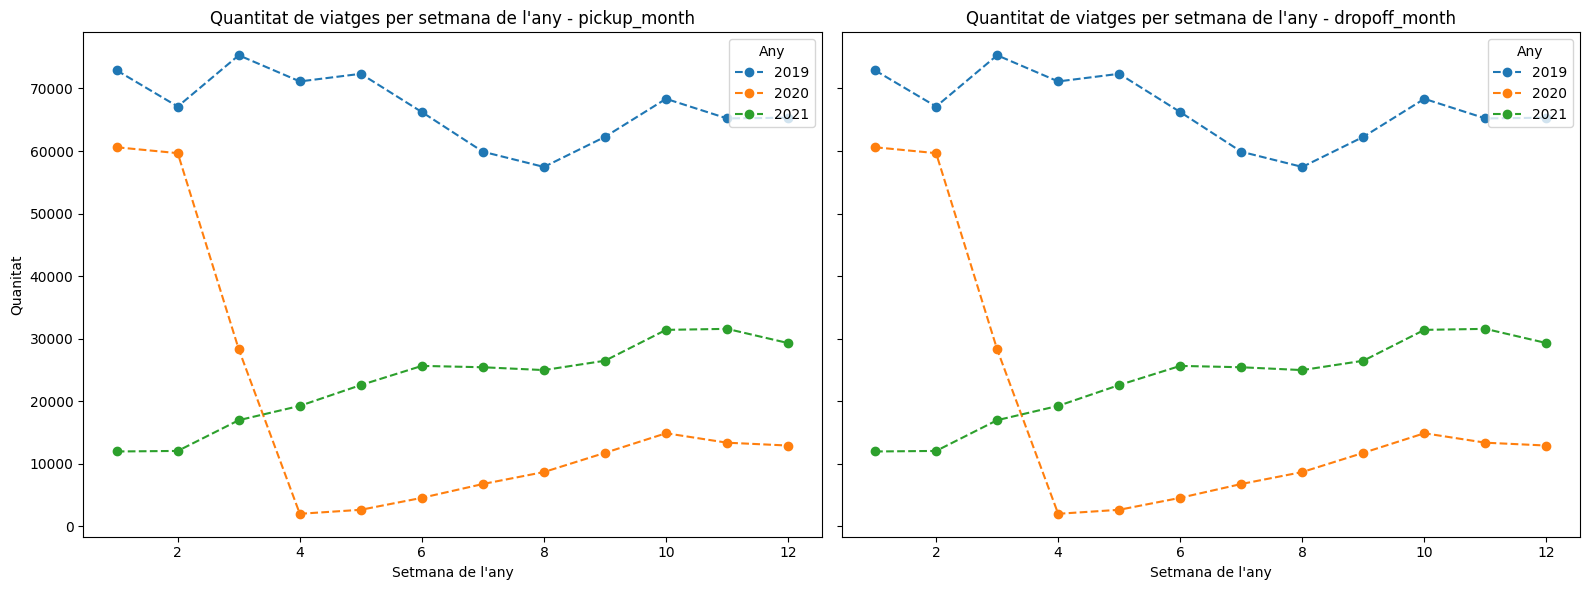

In [22]:
visualize_trips(df,
                ['pickup_month', 'dropoff_month'],
                title = 'Quantitat de viatges per setmana de l\'any',
                xlabel = 'Setmana de l\'any',
                ylabel = 'Quanitat')

+ Com descriurieu l'efecte de la covid en cada cas (si és que en té)? Quin creieu que és el motiu?

> Resposta:
> 
> En la primera gràfica podem veure com té una devallada molt uniforme, donat que la forma segueix mantenint-se, però redueix en nombre
> En la segona gràfica veiem en totes les agregacions tenim una devallada a finals d'any, entenent que donada a les festes i menys mobilitat durant aquest periòde. i podem veure, a part de la devallada del març del 2020, veiem com 2021 segueix la tendencia de recuperació
> i el mateix sembla repetirse en la tercera


## 5. Relació distancia, temps i velocitat

A les dades tenim la **distància** que ha recorregut el taxi en cada viatge i de la informació temporal podem extreure també la **durada** d'aquest.

Ara explorarem com la covid va afectar les distàncies i les durades dels viatges, i també la velocitat dels taxis. També ens preguntarem si la densitat de trànsit va variar.

### Exercici E

+ Per començar, escriu una funció que visualitzi els **histogrames** de distància i durada per any.

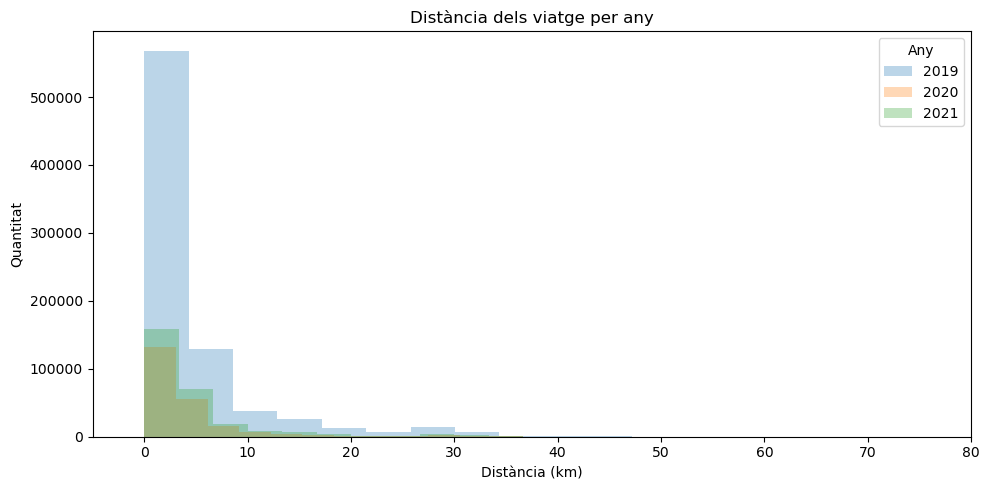

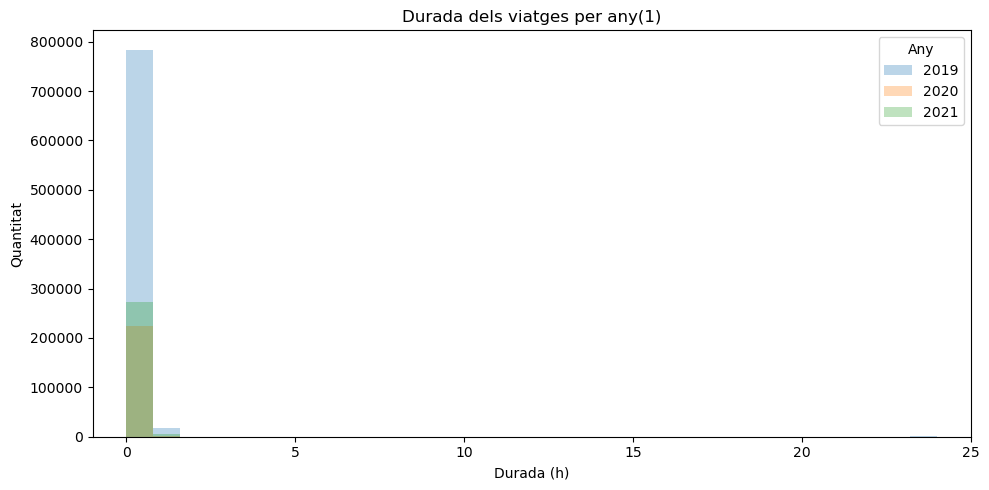

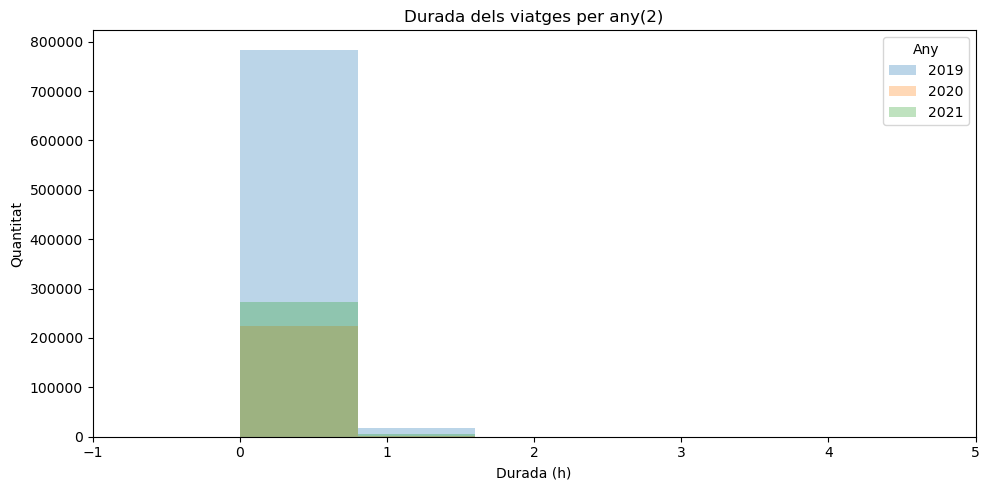

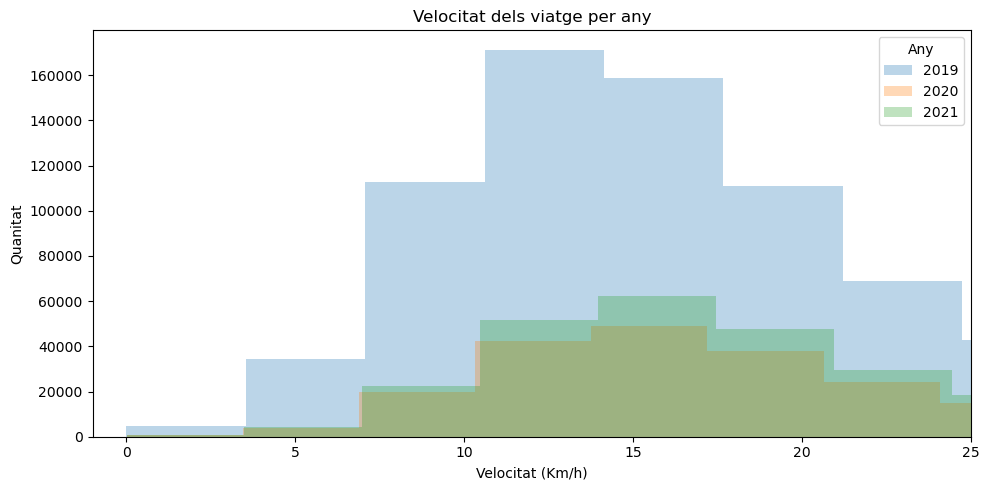

In [56]:
def visualize_histograms(df, column, title, xlabel, ylabel, xlim):
    """
    Funció que crea un histograma a partir de la informació que conté la columna del dataframe
    """

    # Podem sobreposar les columnes amb matplotlib fent-les semitransparents
    # Llegenda sempre !!!

    # AQUÍ EL TEU CODI
    plt.figure(figsize=(10, 5))
    
    for year, subset in df.groupby('year'):
        plt.hist(subset[column], bins=30, alpha=0.3, label=str(year))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title='Any', loc='upper right')
    plt.xlim(xlim)
    plt.tight_layout()
    plt.show()


visualize_histograms(df, 'trip_distance', title = 'Distància dels viatge per any',
                     xlabel = 'Distància (km)', ylabel = 'Quantitat', xlim = (-5, 80))

visualize_histograms(df, 'trip_duration', title = 'Durada dels viatges per any(1)',
                     xlabel = 'Durada (h)', ylabel = 'Quantitat', xlim = (-1, 25) )
#Faig una altre gràfica per a que es vegin millor les dades
visualize_histograms(df, 'trip_duration', title = 'Durada dels viatges per any(2)',
                     xlabel = 'Durada (h)', ylabel = 'Quantitat', xlim = (-1, 5) )

visualize_histograms(df, 'v_mean', title = 'Velocitat dels viatge per any',
                     xlabel = 'Velocitat (Km/h)', ylabel = 'Quanitat', xlim = (-1, 25) )

* Com creieu que la covid va afectar les distàncies i durades dels viatges?

* I a la velocitat dels taxis?

> Resposta:
> 
> Podem veure en els gràfics una davallada en les tres dades, on sorprèn molt la baixada de velocitat mitjana, ja que semblaria que per tenir menys feina potser anirien més ràpid per contentar a la clientela,
> es veu com sembla reduir-se molt, potser indicant una reducció de les retencions i el trànsit.
> 
> La distància mostra un canvi de tendència molt brusc de viatges llargs periòdics a quasi desapareixer


+ velocitat mitja per hora

In [26]:
hourly_mean_speed = df.groupby('pickup_hour')['v_mean'].mean()

print(hourly_mean_speed)

pickup_hour
0     24.343841
1     24.528420
2     24.926303
3     26.150095
4     30.282353
5     32.025669
6     26.065634
7     20.744594
8     17.544706
9     17.134811
10    17.213085
11    16.634980
12    16.530947
13    16.715510
14    16.227019
15    15.941037
16    16.199328
17    16.101615
18    16.714340
19    18.206951
20    19.922935
21    20.852840
22    21.558343
23    22.869888
Name: v_mean, dtype: float64


In [27]:
hourly_weekday_mean_speed = df.groupby(['pickup_hour', 'pickup_day'])['v_mean'].mean()

print(hourly_weekday_mean_speed[2])


pickup_day
0    29.665271
1    27.702287
2    27.235479
3    27.041059
4    26.536698
5    23.403919
6    23.328722
Name: v_mean, dtype: float64


Pregunta:

+ Escriu una funció que identifiqui les cinc ubicacions de recollida (PULocationID) més freqüents.
+ Per a aquestes cinc ubicacions de recollida, calcula el nombre mitjà de passatgers (passenger_count) per trajecte.
+ Filtra els trajectes on la ubicació de recollida i de deixada són la mateixa (PULocationID == DOLocationID). Calcula el percentatge d'aquests trajectes respecte al total de trajectes.

In [28]:
def analyze_pickup_dropoff_locations(df):

    # AQUÍ EL TEU CODI
    #Fem una taula de freqüència agafant els 5 primers valors, ordenats 
    top_pickup_locations = df['PULocationID'].value_counts().head(5)
    #Calculem el nombre mitja
    #Agafem l'index de les primeres pickup
    top_index = top_pickup_locations.index
    #Filtrem per aquests index els passenger counts
    average_passengers = df[df['PULocationID'].isin(top_index)].groupby('PULocationID')['passenger_count'].mean()
    total_trajectes = df['PULocationID'].shape[0]
    filtre = (df['PULocationID'] == df['DOLocationID']).sum()
    percentage_same_location_trips = filtre * 100 / total_trajectes
    
    return {
        'top_pickup_locations': top_pickup_locations,
        'average_passengers': average_passengers,
        'percentage_same_location_trips': percentage_same_location_trips
    }

analyze_pickup_dropoff_locations(df)

{'top_pickup_locations': PULocationID
 237    61152
 236    55626
 161    53154
 186    46540
 162    46525
 Name: count, dtype: int64,
 'average_passengers': PULocationID
 161    1.550175
 162    1.535798
 186    1.521057
 236    1.522795
 237    1.513573
 Name: passenger_count, dtype: float64,
 'percentage_same_location_trips': np.float64(4.9859440439081295)}